# Generation-based MRC

## 1. Generation-based MRC

* Generation-based MRC 문제 정의
  * MRC 문제를 푸는 방법
    1. Extraction-based mrc : 지문(context) 내 답의 위치를 예측 -> 분류 문제(classification)
      * token classification(각 token이 정답인지 확인)
    2. Generation-based mrc : 주어진 지문과 질의 (question)를 보고, 답변을 생성 -> 생성 문제(generation)
      * 주어진 지문에 대한 정답 존재 여부에 상관 없이 생성함
      * 모든 Extraction-based mrc 문제를 Generation-based mrc 문제로 치환 가능함

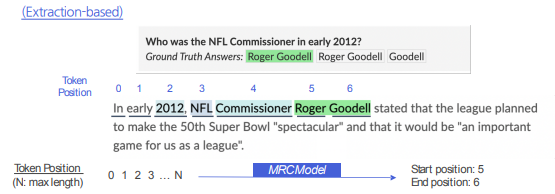

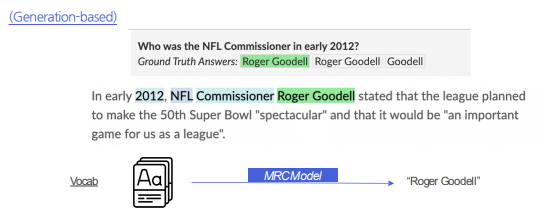

* Generation-based MRC 평가 방법
  * 동일한 extractive answer datasets -> Extraction-based MRC와 동일한 평가 방법을 사용 (recap)
    1. Exact Match (EM) Score
      EM = 1 when <br>(Characters of the predictoin) == (characters of ground-truth)
      <br>Otherwise, EM = 0
    3. F1 Score
      * 예측한 답과 ground-truth 사이의 token overlap을 F1으로 계산함

  * 생성 문제에 일반적으로 접근하면 ROUGE-L, BLEU Score를 사용하기도 함

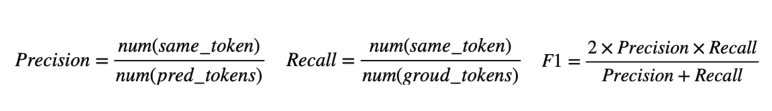

* Generation-based MRC Overview
  * Extraction-based MRC와 거의 윳함
  * 차이점 : Generation-based MRC는 model 에서 정답까지 생성해서 출력함(일종의 seq-to-seq라고 볼 수 있음)
  * 모든 pre-trained language model이 seq-to-seq를 할수 있는것이 아님
    * BERT는 encoding 단계만 있고 decoding 단계가 없어서 Generation-based MRC에 활용할 수 없음

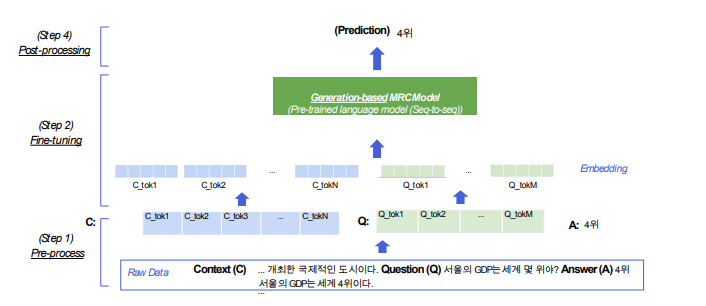

* Generation-based MRC & Extraction-based MRC 비교
  1. MRC 모델 구조
    * Seq-to-seq PLM 구조 (generation) vs. PLM + Classifier 구조 (extraction)
    * generation-based에서 pretrained language model도 seq-to-seq로 학습되어야 함
      * encoder로만 이루어진 classification 위주의 pretrained language model과 차별점을 가짐
  2. Loss 계산을 위한 답의 형태 / Prediction의 형태
    * Free-form text 형태 (generation) vs. 지문 내 답의 위치 (extraction) -> Extraction-based MRC : F1 계산을 위해 text로의 별도 변환 과정이 필요함
    * generation-based에서 text를 decoding할 때, teacher forcing과 같은 방식으로 학습함

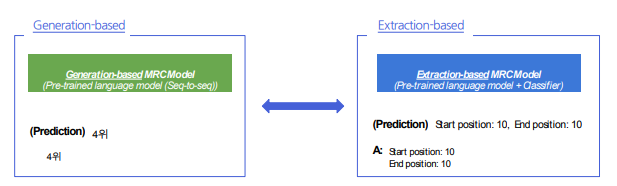

## 2. Pre-processing

* input 단계는 extraction-based와 동일함
* output에서 answer 관련된 pre-processing 필요 없이 정답값 그대로 넘겨주면 됨


* 입력 표현 - 데이터 예시

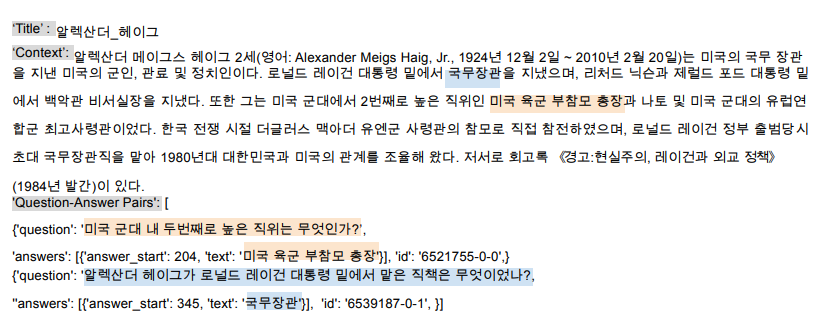

 * 입력 표현 - 토큰화
  * Tokenization(토큰화) : 텍스트를 의미를 가진 작은 단위로 나누 것(형태소)
    * Extraction-based MRC 와 같이 WordPiece Tokenizer를 사용함
      * WordPiece Tokenizer 사전학습 단계에서 먼저 학습에 사용한 전체 데이터 집합(코퍼스)에 대해서 구축되어 있어야함
        * 단어 corpus에 자주 등장하는 단어 순으로 단어화를 함
      * 구축 과정에서 미리 각 단어 토큰들에 대해 순서대로 번호(인덱스)를 부여해둠
    * Tokenizer은 입력 텍스트를 토큰화한 뒤, 각 토큰을 미리 만들어둔 단어 사전에 따라 인덱스로 변환함
  
  * WordPiece Tokenizer 사용 예시
    <br> 질문 : '미국 군대 내 두번째로 높은 직위는 무엇인가?'
    <br> 토큰화된 질문 : ['미국', '군대', '내', '두번째', '**##로**', '높은', '직', '**##위는**', '무엇인가', '?']
    <br> 인덱스로 바뀐 질문 : [101, 23545, 8910, 14423, 8996, 9102, 48506, 11261, 55600, 9707, 19855, 11018, 9294, 119137, 12030, 11287, 136, 102]
    <br>
    <br> => 인덱스로 바뀐 질문을 보통 input_ids(또는 input_token_ids)로 부름
    <br> => 모델의 기본 입력은 input_ids만 필요하나, 그 외 추가적인 정보가 필요함

* 입력 표현 - Special Token
  * 학습 시에만 사용되며 단어 자체의 의미는 가지지 않는 특별한 토큰
    * SOS(Start Of Sentence), EOS(End Of Sentence), CLS, SEP, PAD, UNK 등등
    <br> => Extraction-based MRC에선 **CLS, SEP, PAD** 토큰을 사용함
    <br> => Generation-based MRC에서도 PAD 토큰은 사용됨. CLS, SEP 토큰 또한 사용할 수 있으나, 대신 자연어를 이용하여 정해진 텍스트 포맷(format)으로 데이터를 생성함(사용하는 모델에 따라 다름)

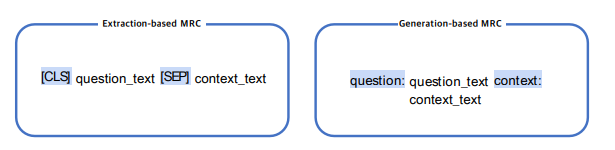

* 입력 표현 - additional information
  * Attention mask
    * Extraction-based MRC 와 똑같이 어텐션 연산을 수행할 지 결정하는 어텐션 마스크 존재
  * Token type ids
    * BERT(Extraction-based에서 사용함) 와 달리 BART에서는 입력시퀀스에 대한 구분이 없어 token_type_ids가 존재하지 않음
    * 따라서 Extraction-based MRC와 달리 입력에 token_type_ids가 들어가지 않음
      * 초반에는 spacial token으로 구분, 나중에는 크게 중요하지 않게됨

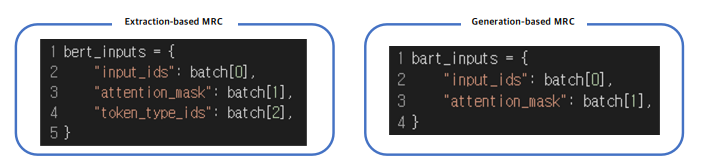

* 출력 표현 - 정답 출력
  * Sequence of token ids
    * output이 예측한 정답을 내보내기 때문에 start/end의 위치가 아닌 해당 text의 id를 출력
    * Extraction-based MRC에선 텍스트를 생성해내는 대신 시작/끝 토큰의 위치를 출력하는 것이 모델의 최종 목표였음
    * Generation-based MRC는 그보다 조금 더 어려운 실제 텍스트를 생성하는 과제를 수행
    * 전체 시퀀스의 각 위치마다 모델이 아는 모든 단어들 중 하나의 단어를 맞추는 classification 문제

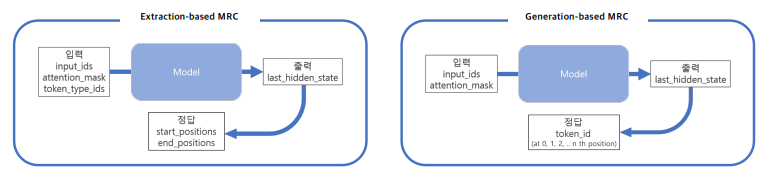

* 도식화한 아래 과정을 거쳐 생성된 단어들을 합쳐서 최종 답으로 예측함
  * 일반적인 decoding 과정

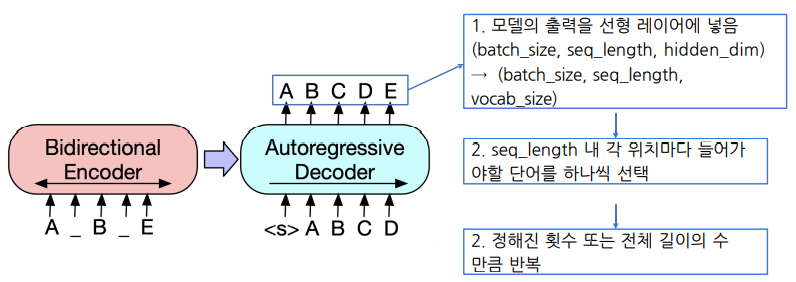

## 3. Model

* BART
  * 기계 독해, 기계 번역, 요약, 대화 등 sequence to sequence 문제의 pre-training을 위한 denosing autoencoder


* BERT는 단어를 mask 하여 알아맞추는 방식으로 진행함
* GPT같은 경우는 다음단어를 알아맞추는 방식으로 진행함
* BART는 기존 문장을 BERT와 비슷한 방식으로 mask 하지만 mask를 알아맞추는 방식이 아닌 정답을 생성하는 방식으로 진행함
  * denosing autoencoder
    * noise를 injection하고, noise가 없었던 원래 버전을 reconstructure하는 문제
  

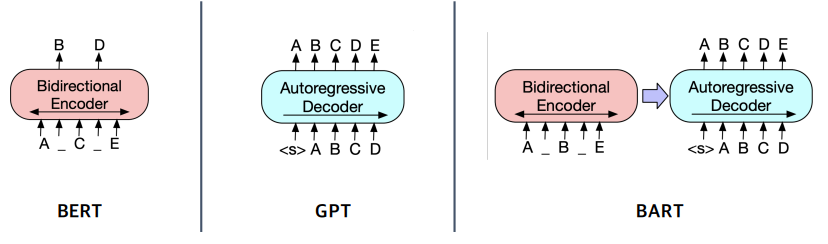

* BART Encoder & Decoder
  * BART의 인코더는 BERT 처럼 bi-directional
  * BART의 디코더는 GPT 처럼 uni-directional(autoregressive)
    * attention mask도 활용하여 앞에 있는 단어들을 보지 않을 수 있도록하여 학습하게 함

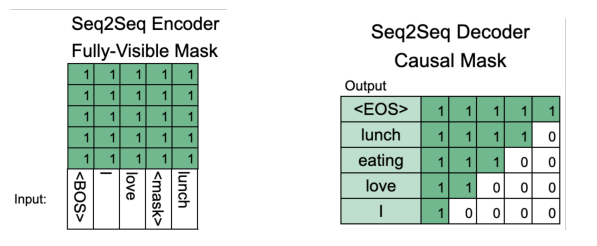

* Pre-training BART
  * BART는 텍스트에 노이즈를 주고 원래 텍스트를 복구하는 문제를 푸는 것으로 pre-training함
  * 생성 쪽으로 용이함

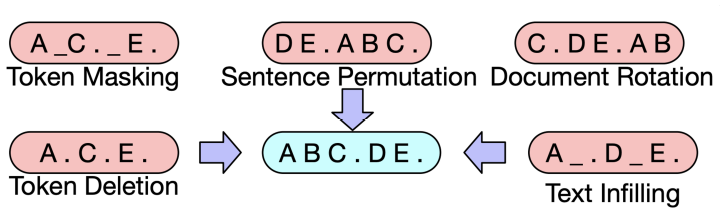

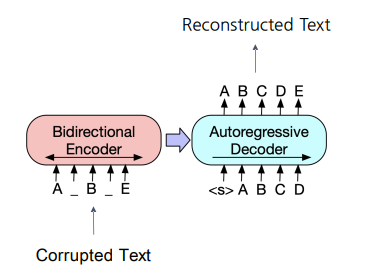

## 4. Post-processing

* Decoding
  * 디코더에서 이전 스텝에서 나온 출력이 다음 스텝의 입력으로 들어감(autoregressive)
  * 맨 처음 입력은 문장 시작을 뜻하는 special token

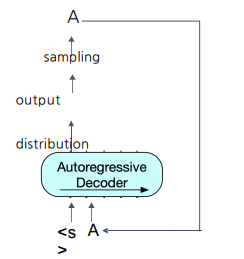

* Searching
  * Greedy search : decoding 방법론중 가장 simple한 방법론
    * 가장 likely한 정답을 선택함
    * 처음 선택이 잘못된 선택인 경우 상당히 안좋은 output을 내게 됨
  * Exhaustive search
    * 모든 가능성을 다 확인함
    * 가능한 가짓수가 timestep에 비례하여 exponential하게 늘어나기 때문에 문장이 조금만 길어지거나 vocabulary size가 조금만 늘어나도 불가능한 방법론
  * Beam Search : 일반적으로 이와 유사한 방법론을 채택함
    * exhaustive search를 하지만 각 timestep마다 가장 점수가 높은 top-k만 유지하는 방식을 취함
    * 각 timestep 마다 특정 개수를 유지하기 위해 reranking을 하고, ranking이 내려간 candidate는 버림

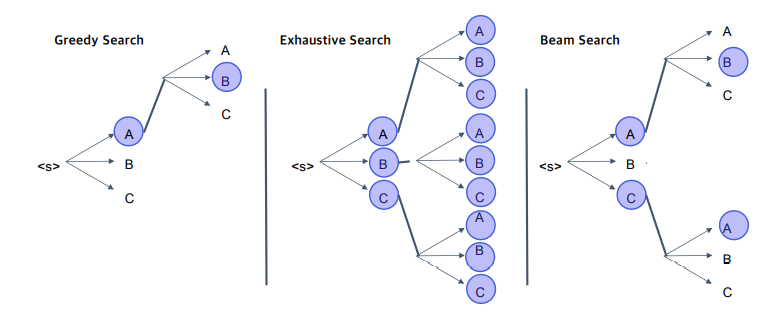